# Parameter Estimation and Model Selection for the Influenza Season 2017/18

### Seminar Hands-On Mathematical Models in Biology - Heidelberg University, summer term 2019


**Authors:** Abhit Patil, Debora Fieberg, Fabian Hartung, Francesca Loparco <br>
**Supervisors:** Dr. Maria Barbarossa, Prof. Dr. Ekaterina Kostina

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, interpolate
from scipy import optimize

## Importing the Data

We are using the dataset, which can be downloaded from the CDC FluView wepage: <br>
https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html *(Line Chart ILINet of season 2017/18)*

Download the data and change the path of the following code accordingly.

In [16]:
data = pd.read_csv(r"C:\Users\fabia\OneDrive\Desktop\Seminar\Datas\ILINet.csv",skiprows=[0])
data.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,National,X,2017,40,1.26589,1.28020,3849,2488,X,4556,1071,875,12839,2220,1002892
1,National,X,2017,41,1.30479,1.33123,4118,2676,X,4453,1073,947,13267,2245,996595
2,National,X,2017,42,1.34075,1.40786,4408,2805,X,4993,1139,974,14319,2266,1017076
3,National,X,2017,43,1.51674,1.57220,5006,2922,X,5531,1324,1049,15832,2266,1006998
4,National,X,2017,44,1.74583,1.70326,5219,3289,X,6134,1365,1062,17069,2222,1002140


The data is porvided for many different age groups as one can see in the following plot.

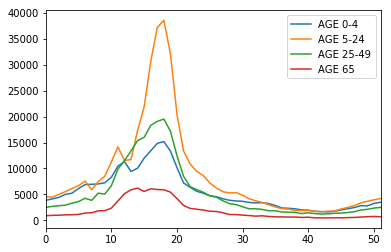

In [17]:
data.loc[:,['AGE 0-4','AGE 5-24','AGE 25-49','AGE 25-64','AGE 65']].plot()
plt.show()

However, we are just interested in the overall behaviour of influenza for the American population. Thus, we are using the summarized data in percentage. As one can see in the next figure, the difference between unweighted and weighted percentages is not very large. We choose to work with the weighted data in percentage.

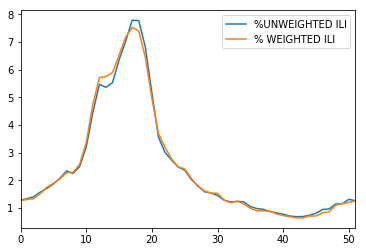

In [18]:
data.loc[:,['%UNWEIGHTED ILI','% WEIGHTED ILI']].plot()
plt.show()

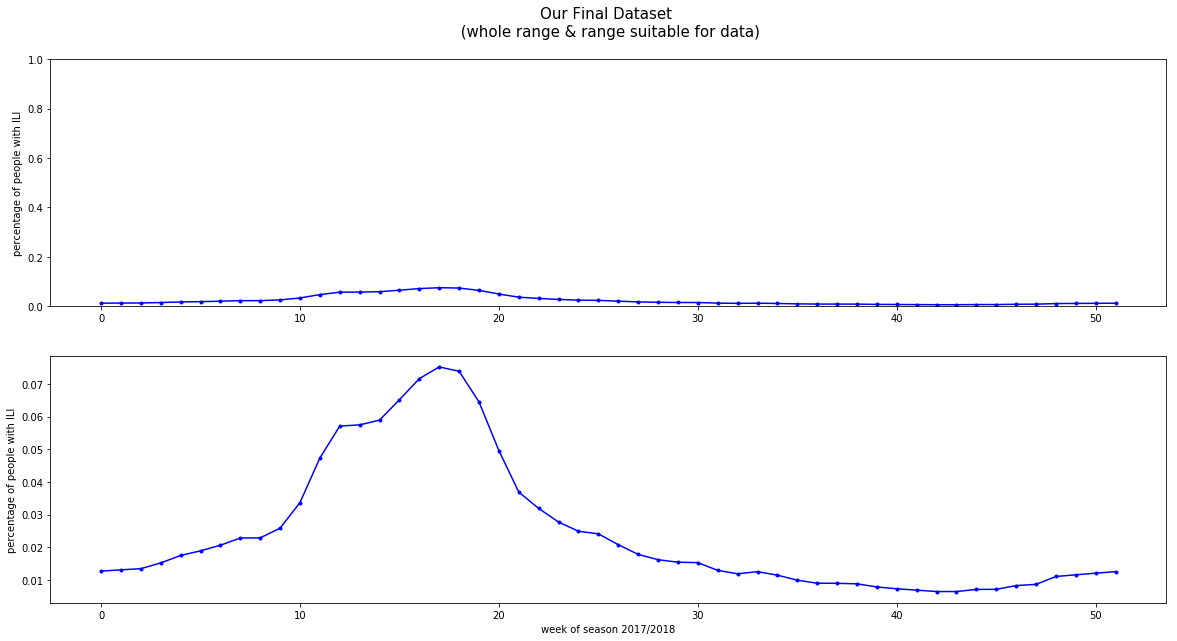

In [19]:
y_data = np.array(data['% WEIGHTED ILI']) # in percentage
x_data = np.linspace(0,len(y_data)-1,len(y_data))
N = 100 # as the data is given in percentage, our population has 100 people
y_data = y_data/N

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Our Final Dataset \n (whole range & range suitable for data)\n',fontsize=15)
plt.plot(y_data,'.-',color='blue')
plt.ylim(0,1)
#plt.ylim(0,N)
plt.ylabel('percentage of people with ILI')
plt.subplot(212)
plt.plot(y_data,'.-',color='blue')
#plt.ylim(0,100)
plt.ylabel('percentage of people with ILI')
plt.xlabel('week of season 2017/2018')
plt.show()

## Defining Functions for the Analyis

In the following, we define necessary functions needed for the fitting and selection process. <br>
In particular, these functions are:
* the ode system of the desired model in function **f**
* the setup with intial guesses and parameters etc. in the **setup** function
* optimization related functions **ode_least_squares**, **f_resid**, and **f_leastsquares**
* calculation of the AIC and BIC via **calc_AIC_AICc**, **calc_BIC**

The initial guess for the model parameters was obtained by a prefit. We ran the routine once with SLSQP and positive bounds enforced, using some different intital guess with parameters between 0 and 2. The results were then rounded to 2 decimals of the solution.

For the initial compartment sizes we assumed $I_0 = \texttt{y_data[0]}$, $S_0 = \texttt{1-y_data[0]}$ and all other compartments empty (if the initial values were not included in the parameters to be fitted - in this case the initial guess for the inital compartment size was always set to be $0.01$).

In [20]:
def setup(model):
    """ initial parameters and inital compartment sizes for models described in function f """
    
    upperbound = np.inf # no upper bound, we just want the parameters to be positive 
    
    if model == 1:
        print('\n--- SIR --------------') 
        guess = [ 0.60, 0.43 ] # beta, alpha
        y0    = [1-y_data[0],y_data[0],0] # S,I,R init
        para_names = ['beta','alpha']
        compartment_names = ['susceptibles','infected','recovered']
        bnds  = ((0,upperbound),(0,upperbound))
        return guess, y0, para_names, compartment_names, bnds, 'SIR'
        
    elif model == 2:
        print('\n--- SEIR --------------') 
        guess = [ 0.94, 0.57, 1.08 ] # beta, alpha, eta          
        y0    = [1-y_data[0],0,y_data[0],0] # S,E,I,R init
        para_names = ['beta','alpha','eta']
        compartment_names = ['susceptibles','exposed','infected','recovered']
        bnds  = ((0,upperbound),(0,upperbound),(0,upperbound))
        return guess, y0, para_names, compartment_names, bnds, 'SEIR'
            
    elif model == 3:
        print('\n--- SEIAR --------------') 
        guess = [ 0.81, 0.49, 0.44, 1.27, 0.38, 0.40 ] # beta,alpha,eta,qpara,ppara,gamma         
        y0    = [1-y_data[0],0,y_data[0], 0, 0] # S,E,I,A,R init
        para_names = ['beta','alpha','eta','q','p','gamma']
        compartment_names = ['susceptibles','exposed','infected','asymptomatic','recovered']
        bnds  = ((0,upperbound),(0,upperbound),(0,upperbound),(0,upperbound),(0,upperbound),(0,upperbound))
        return guess, y0, para_names, compartment_names, bnds, 'SEIAR'
        
    elif model == 4:
        print('\n--- SEIAQR --------------') 
        guess = [ 0.91, 1.25, 0.35, 1.16, 0.17, 0.04, 0.35, 1.00 ] # beta,alpha,eta,qpara,ppara,gamma,delta,my   
        y0    = [1-y_data[0], 0, y_data[0], 0, 0, 0] # S,E,I,A,Q,R init
        para_names = ['beta','alpha','gamma','eta','q','p','gamma','delta','my']
        compartment_names = ['susceptibles','exposed','infected','asymptomatic','querentined','recovered']
        bnds  = ((0,upperbound),(0,upperbound),(0,upperbound),(0,upperbound),(0,upperbound),
                 (0,upperbound),(0,upperbound),(0,upperbound))
        return guess, y0, para_names, compartment_names, bnds, 'SEIAQR'
        
    
    elif model == 5:
        print('\n--- SIQR --------------') 
        guess = [ 0.60, 0.41, 0.01, 1.16] # beta,alpha,delta,my  
        y0    = [1-y_data[0], y_data[0], 0, 0] # S,I,Q,R init
        para_names = ['beta','alpha','delta','my']
        compartment_names = ['susceptibles','infected','quarentined','recovered']
        bnds  = ((0,upperbound),(0,upperbound),(0,upperbound),(0,upperbound))
        return guess, y0, para_names, compartment_names, bnds, 'SIQR'
        
    elif model == 6:
        print('\n--- SEIR + E0 --------------') 
        print('Setup using model 2 and manual changes... ')
           
        
    elif model == 7:
        print('\n--- SEIAR + A0 --------------') 
        print('Setup using model 3 and manual changes... ')
        
    else:
        print('Define valid model!')

In [21]:
def f(y, t, k, model): 
    """system of odes defined for different models"""
    
    if model==1:
        # model components and parameters_
        S,I,R        = y
        beta, alpha  = k
        # model equations:
        dS = -beta*S*I
        dI = beta*S*I-alpha*I
        dR = alpha*I
        return (dS,dI,dR)
    
    elif model == 2:
        # model components and parameters_
        S,E,I,R = y
        beta, alpha, eta = k
        # model equations:
        dS = -beta*S*I
        dE = beta*S*I-eta*E
        dI = eta*E-alpha*I
        dR = alpha*I
        return (dS,dE,dI,dR)
    
    elif model == 3:
        # model components and parameters_
        S,E,I,A,R = y
        beta,alpha,eta,qpara,ppara,gamma =k
        # model equations:
        dS = -beta*S*(I+qpara*A)
        dE = beta*S*(I+qpara*A)-eta*E
        dI = ppara*eta*E-alpha*I
        dA = (1-ppara)*eta*E-gamma*A
        dR = alpha*I+gamma*A
        return (dS,dE,dI,dA,dR)
    
    elif model == 4:
        # model components and parameters_
        S,E,I,A,Q,R = y
        beta,alpha,eta,qpara,ppara,gamma,delta,my =k
        # model equations:
        dS = -beta*S*(I+qpara*A)
        dE = beta*S*(I+qpara*A)-eta*E
        dI = ppara*eta*E-(alpha+delta)*I
        dA = (1-ppara)*eta*E-gamma*A
        dQ = delta*I-my*Q
        dR = alpha*I+gamma*A+my*Q
        return (dS,dE,dI,dA,dQ,dR)

    elif model == 5:
        # model components and parameters_
        S,I,Q,R = y
        beta,alpha,delta,my =k
        # model equations:
        dS = -beta*S*I
        dI = beta*S*I-(alpha+delta)*I
        dQ = delta*I-my*Q
        dR = alpha*I+my*Q
        return (dS,dI,dQ,dR)

    elif model == 6: # actually exactly the same as in SEIR (model 2)
        # model components and parameters_
        S,E,I,R = y
        beta, alpha, eta = k
        # model equations:
        dS = -beta*S*I
        dE = beta*S*I-eta*E
        dI = eta*E-alpha*I
        dR = alpha*I
        return (dS,dE,dI,dR)
    
    elif model == 7: # actually the same as in SEIAR (model 3)
        # model components and parameters_
        S,E,I,A,R = y
        beta,alpha,eta,qpara,ppara,gamma =k
        # model equations:
        dS = -beta*S*(I+qpara*A)
        dE = beta*S*(I+qpara*A)-eta*E
        dI = ppara*eta*E-alpha*I
        dA = (1-ppara)*eta*E-gamma*A
        dR = alpha*I+gamma*A
        return (dS,dE,dI,dA,dR)
    
    else:
        print('Define valid model!')

In [22]:
def ode_least_squares(datapoints,paras2fit):
    """datapoints gives evaluation points, paras2fit is an array of parameters to be varied for fit"""
    # create a function of f with y and t only
    f2 = lambda y,t: f(y, t, paras2fit, model)
    # calculate ode solution
    r = integrate.odeint(f2,y0,datapoints)
    # we only need the solution of the infected compartment
    if model == 1 or model == 5: 
        return r[:,1] # only for SIR (I on second position) ...also for SIQR
    else: 
        return r[:,2] # SEIR for example... (I on third position)

def f_resid(p):
    """ function to pass to optimize.leastsq"""
    return y_data-ode_least_squares(x_data,p)

def f_leastsquares(p):
    """ function to pass to optimize.minimize"""
    return sum(np.array(y_data-ode_least_squares(x_data,p))**2)

In [23]:
# especiall for E0 fitting in SEIR

def f_leastsquares_E0(p):
    """ function to pass to optimize.minimize"""
    return sum(np.array(y_data-ode_least_squares_E0(x_data,p))**2)

def ode_least_squares_E0(datapoints,paras2fit):
    """datapoints gives evaluation points, paras2fit is an array of parameters to be varied for fit"""
    # create a function of f with y and t only
    f2 = lambda y,t: f(y, t, paras2fit[:-1], model)
    # calculate ode solution
    r = integrate.odeint(f2,[y0[0],paras2fit[-1],y0[2],y0[3]],datapoints)
    # we only need the solution of the infected compartment
    return r[:,2] # SEIR (I on third position)

In [24]:
# especiall for A0 fitting in SEIAR

def f_leastsquares_A0(p):
    """ function to pass to optimize.minimize"""
    return sum(np.array(y_data-ode_least_squares_A0(x_data,p))**2)

def ode_least_squares_A0(datapoints,paras2fit):
    """datapoints gives evaluation points, paras2fit is an array of parameters to be varied for fit"""
    # create a function of f with y and t only
    f2 = lambda y,t: f(y, t, paras2fit[:-1], model)
    # calculate ode solution
    r = integrate.odeint(f2,[y0[0],y0[1],y0[2],paras2fit[-1],y0[4]],datapoints)
    # we only need the solution of the infected compartment
    return r[:,2] # SEIAR (I on third position)

In [25]:
# formular source: https://www.jmp.com/support/help/14-2/likelihood-aicc-and-bic.shtml

def calc_AIC_AICc(SSE,n_paras,N_data):
    """ As on pp. 135-136 in Martcheva's Introduction to Mathematical Epidemiology"""
    AIC  = N_data * (np.log(SSE/N_data))+2*(n_paras+1)
    AICc = N_data * (np.log(SSE/N_data))+2*(n_paras+1)+ 2*(n_paras+1)*(n_paras+2)/(N_data-(n_paras+1)-1)
    return AIC, AICc

def calc_BIC(SSE,n_paras,N_data):
    BIC = N_data * (np.log(SSE/N_data))+(n_paras+1)*np.log(N_data)+N_data*np.log(2*np.pi)+N_data
    return BIC

## Fitting the Data

We shall now fit the data for several models with several different minimization methods, which should be selected first. We are also calculating the AIC and other measurements of model comparison.

One minimization method is the built in leastsq of scipy.optimize:
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html

The other minimization can be done with 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

by choosing specific methods as described on the webpage.


--- SIR --------------

Parameter solution:    [0.60368836 0.42556909]
SSE:                     0.0037555567308357705
AIC:                     -489.85964789225403
AICc:                    -489.35964789225403
BIC:                     -336.43630928322375
R0 approximation:        2.077173416631751


No handles with labels found to put in legend.


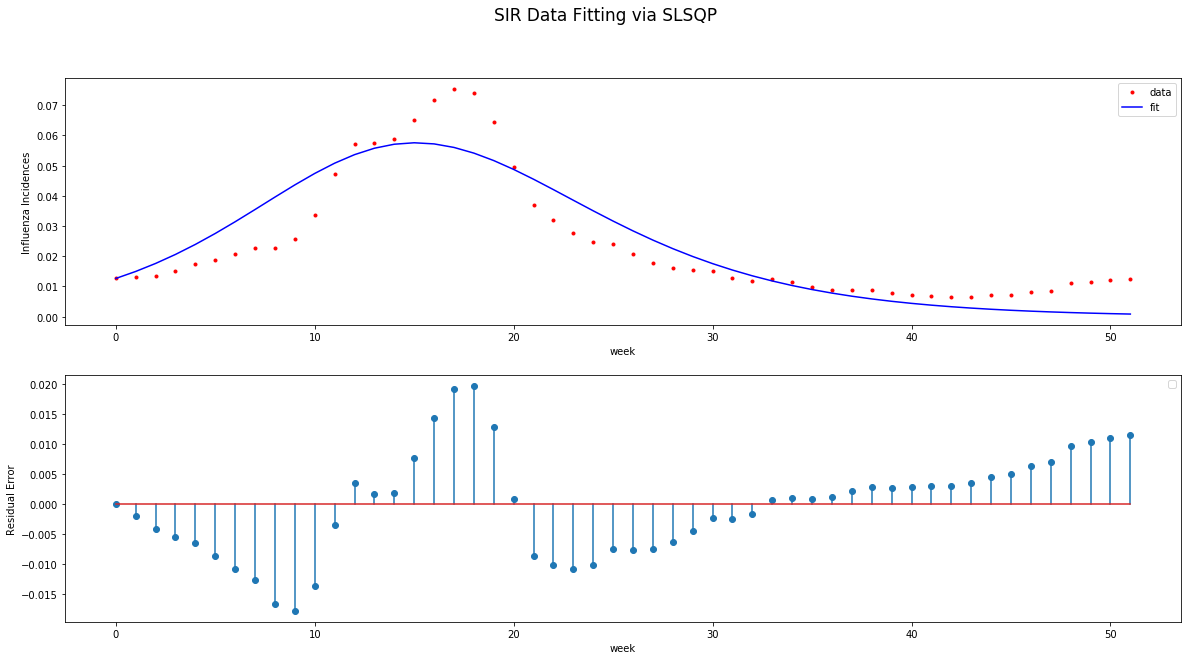

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


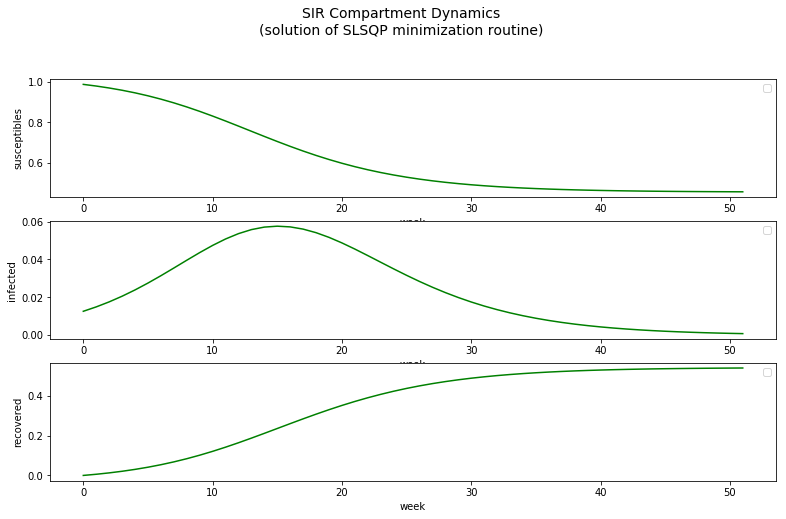

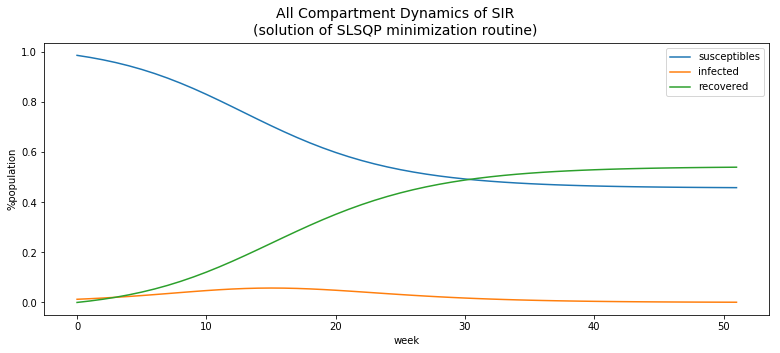

C:\Users\fabia\Anaconda3\lib\site-packages\ipykernel_launcher.py:249: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

No handles with labels found to put in legend.



--- SEIR --------------

Parameter solution:    [0.93858096 0.57273552 1.07971816]
SSE:                     0.002580692297554352
AIC:                     -507.36894771644495
AICc:                    -506.5178838866577
BIC:                     -351.99436538883333
R0 approximation:        2.3905287308375165


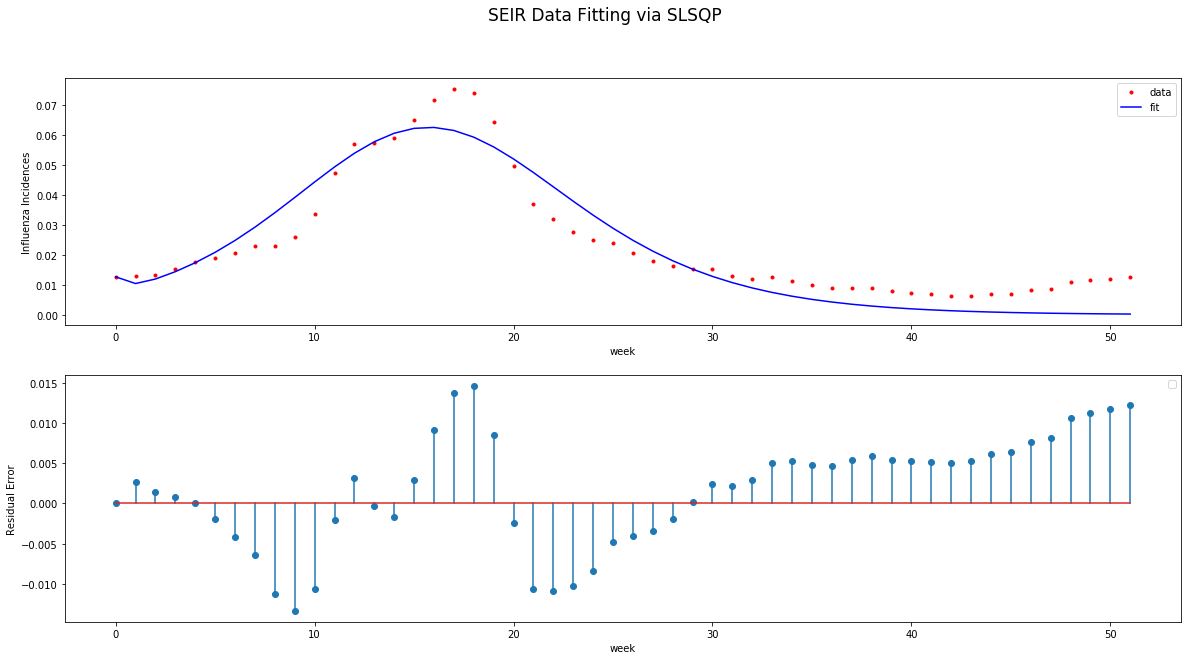

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


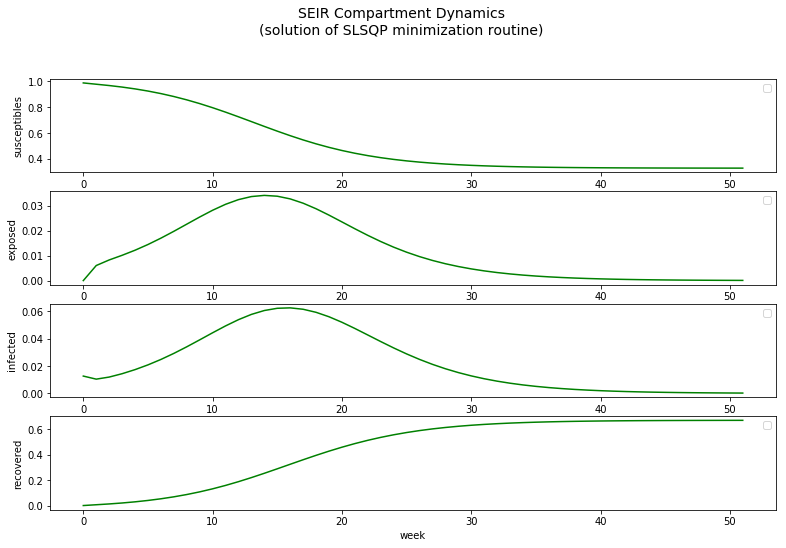

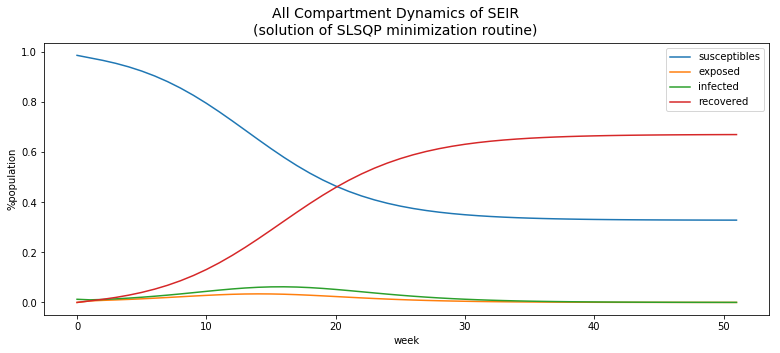

No handles with labels found to put in legend.



--- SEIAR --------------

Parameter solution:    [0.93067831 0.27077292 0.666904   1.21603175 0.33611744 0.59542281]
SSE:                     0.0021131049471336647
AIC:                     -511.7637108257086
AICc:                    -509.218256280254
BIC:                     -350.53539734235267
R0 approximation:        3.5273567356094673


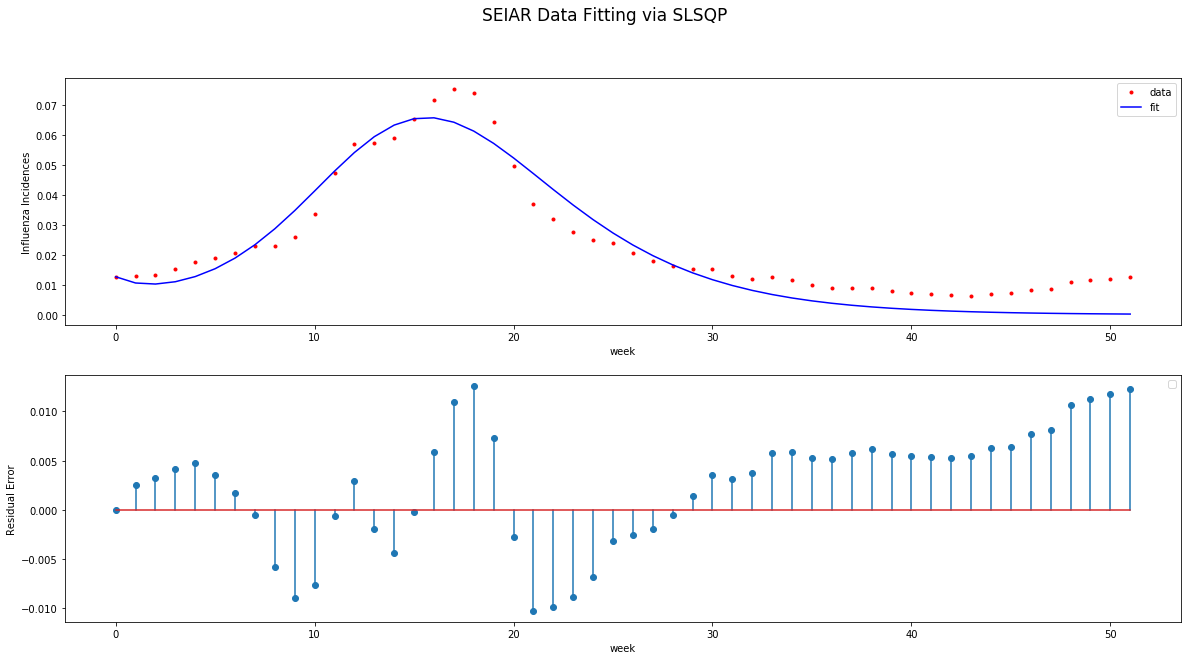

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


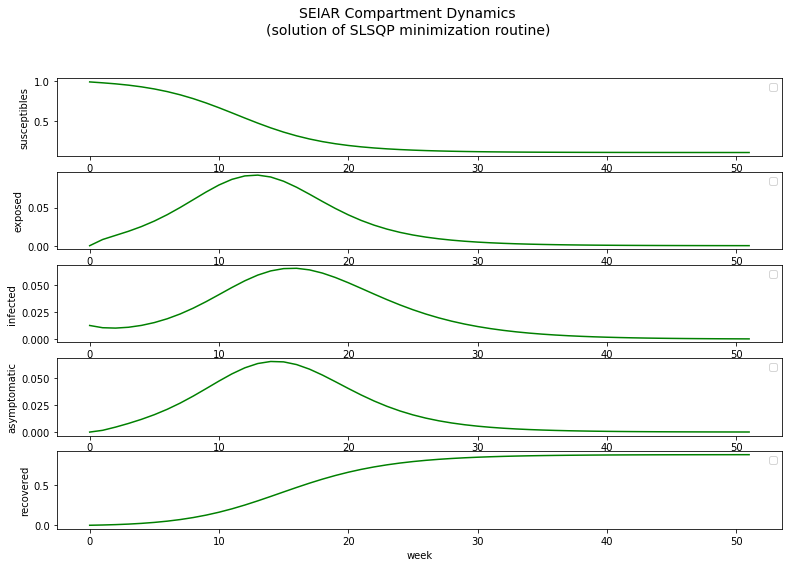

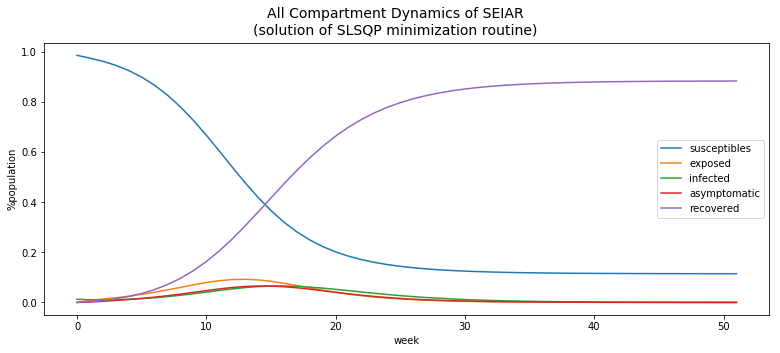


--- SEIAQR --------------


No handles with labels found to put in legend.



Parameter solution:    [1.21871342e+00 7.39386284e-01 7.41182140e-01 1.39099369e+00
 9.73721472e-01 0.00000000e+00 2.13308414e-20 9.99997765e-01]
SSE:                     0.0013580285014276328
AIC:                     -530.7541790042422
AICc:                    -526.4684647185279
BIC:                     -365.6233780837234
R0 approximation:        4.415931831110993


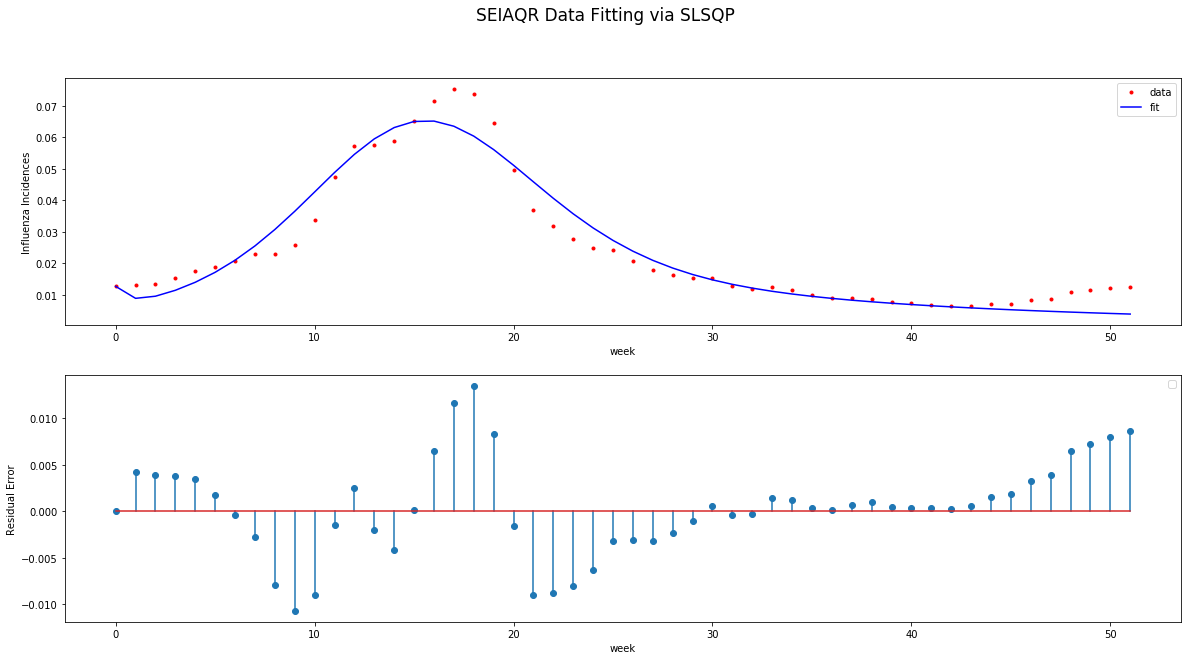

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


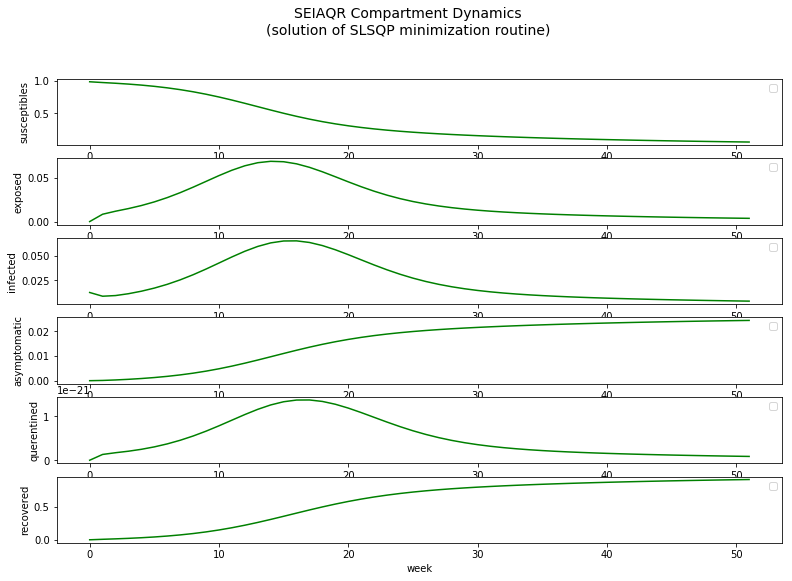

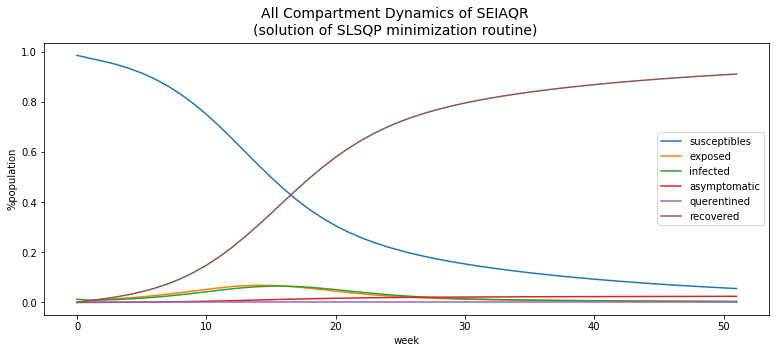

No handles with labels found to put in legend.



--- SIQR --------------

Parameter solution:    [0.60327784 0.41260919 0.01261519 1.16000007]
SSE:                     0.003755787353342527
AIC:                     -485.856454756586
AICc:                    -484.55210693049906
BIC:                     -328.5306287103929
R0 approximation:        2.077416439660336


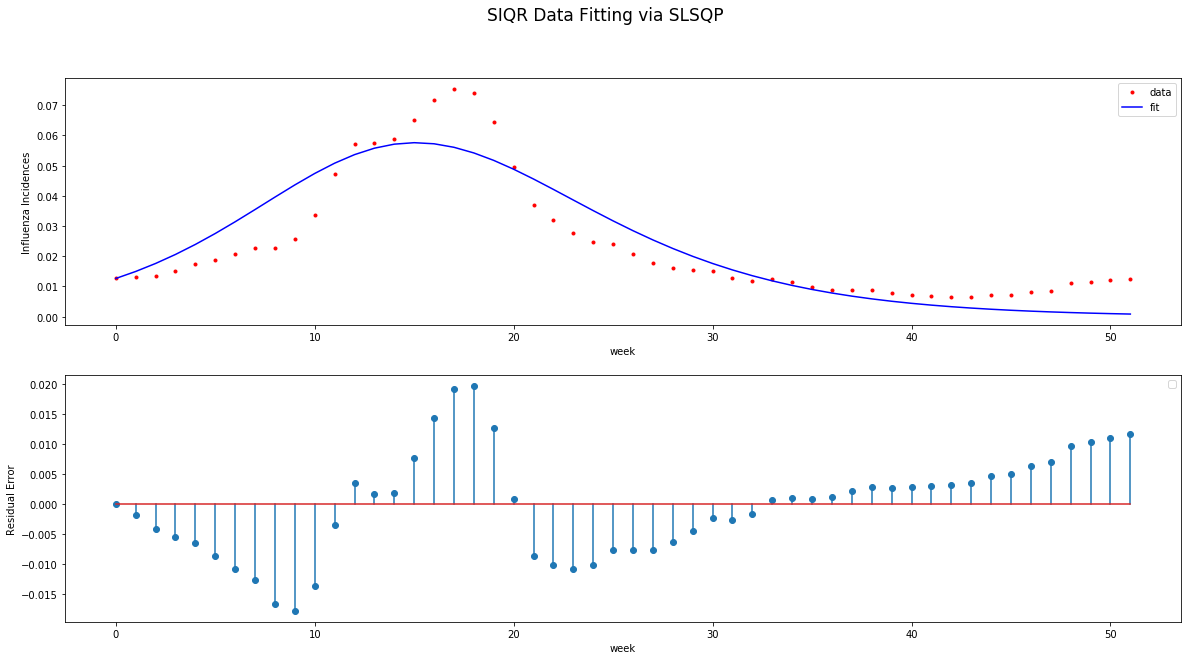

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


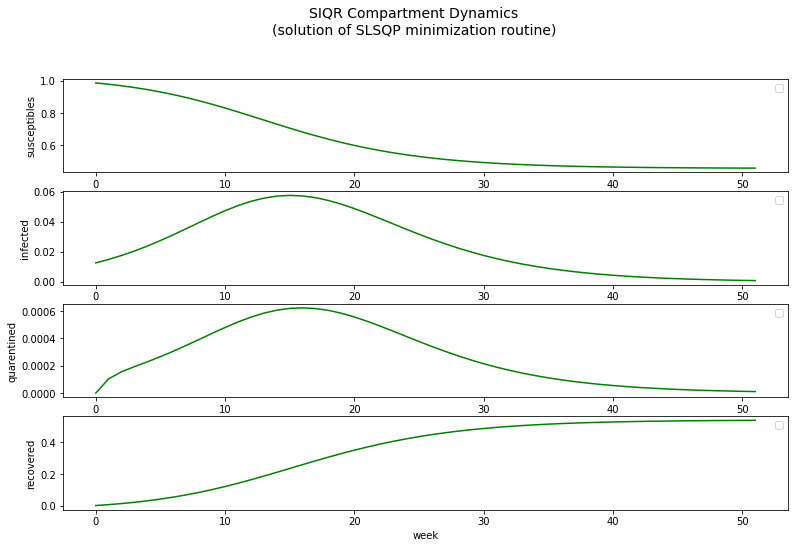

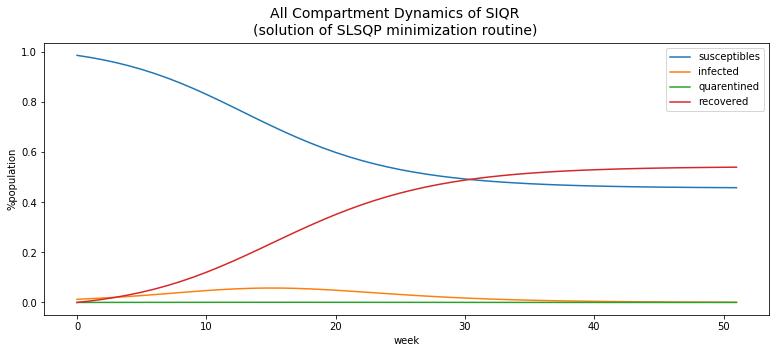

No handles with labels found to put in legend.



--- SEIR --------------
--- ...plus fitting E0

[0.9873411, 4.307521164390998e-17, 0.012658899999999999, 0]

E0_solution:    4.307521164390998e-17

Parameter solution:    [1.07061027e+00 6.17945265e-01 8.08410381e-01 4.30752116e-17]
SSE:                     0.0024575033206679347
AIC:                     -507.91235981092757
AICc:                    -506.60801198484063
BIC:                     -350.58653376473444
R0 approximation:        2.5243817032967324


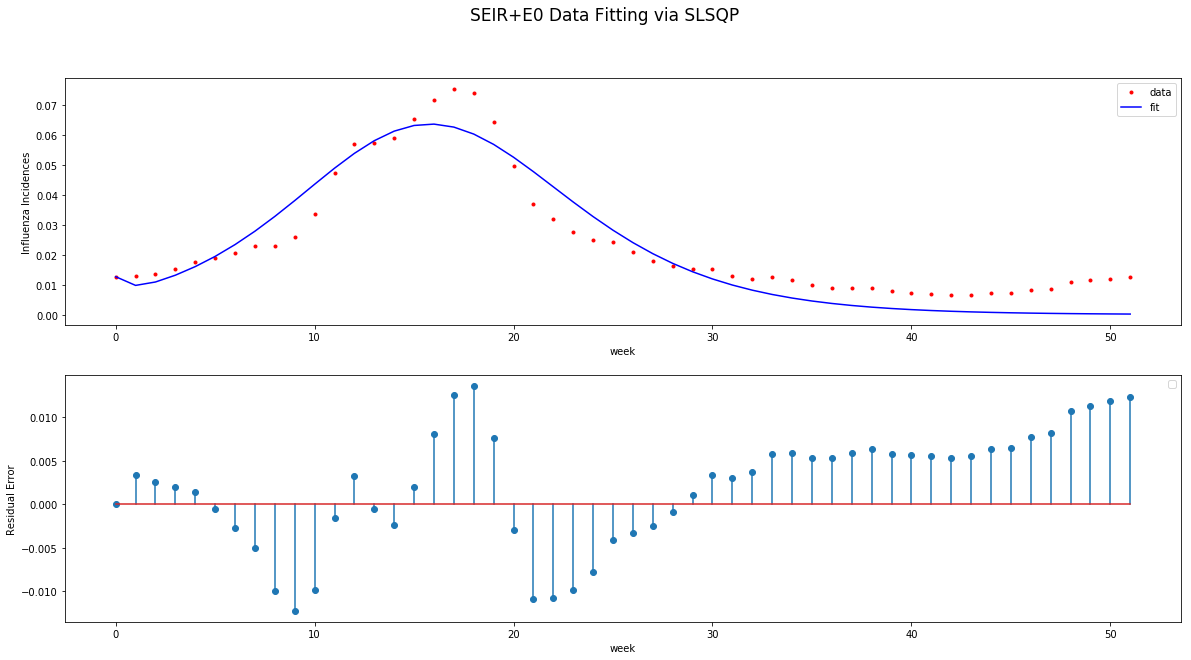

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


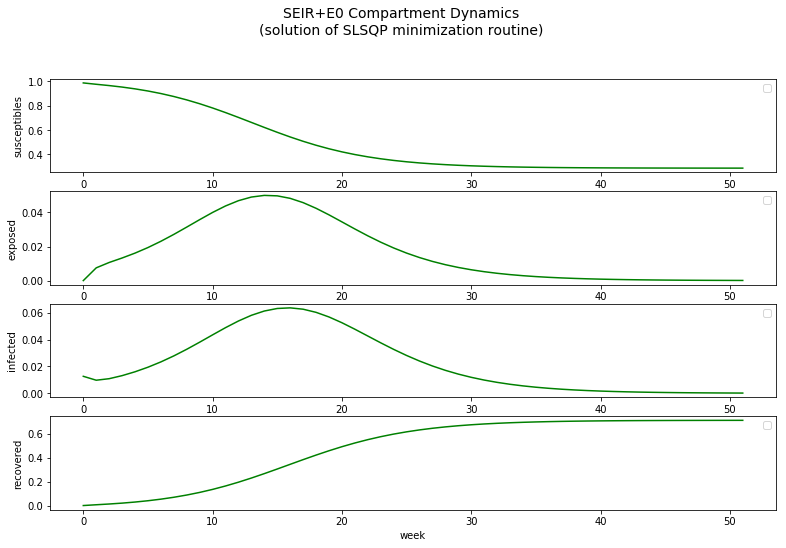

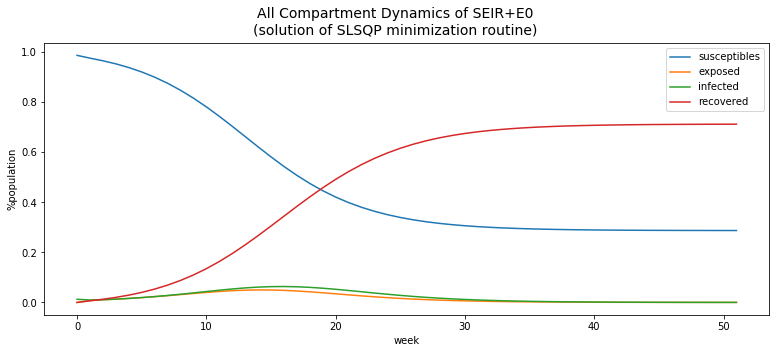


--- SEIAR --------------
--- ...plus fitting A0



No handles with labels found to put in legend.


[0.9873411, 0.004110229967676368, 0.012658899999999999, 0]

A0_solution:    0.004110229967676368

Parameter solution:    [0.87533657 0.3337598  0.46552493 1.26881054 0.38093466 0.34159131
 0.00411023]
SSE:                     0.0021642393169804095
AIC:                     -508.5203627347897
AICc:                    -505.1715255254874
BIC:                     -345.3408055328523
R0 approximation:        4.376205291126044


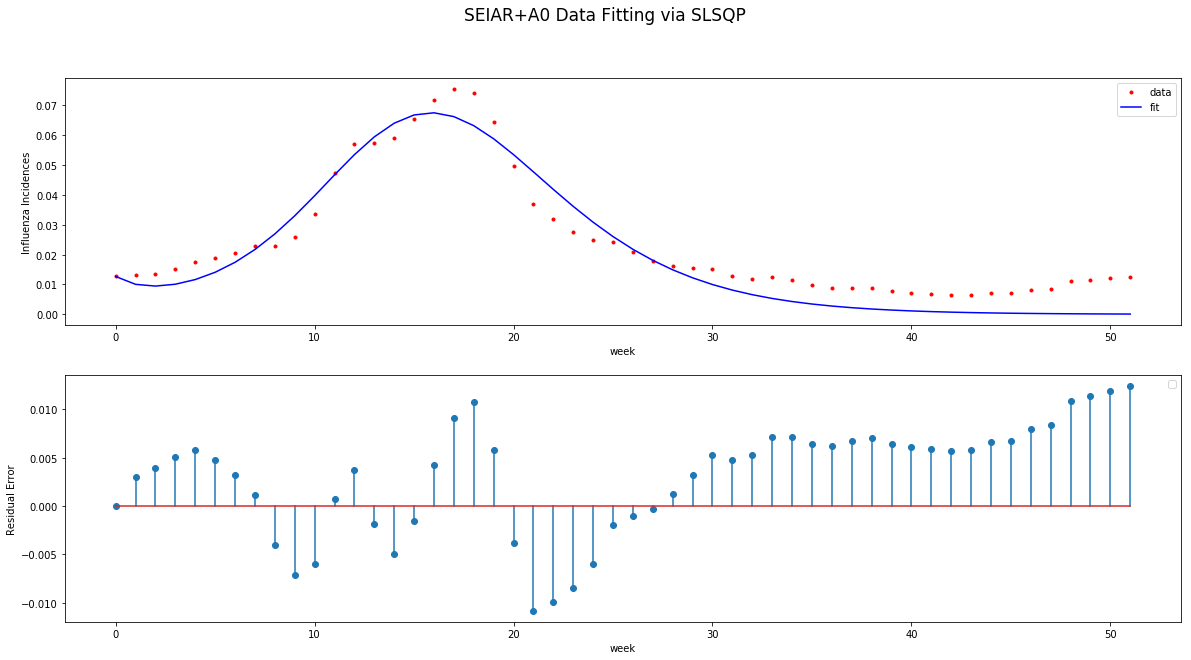

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


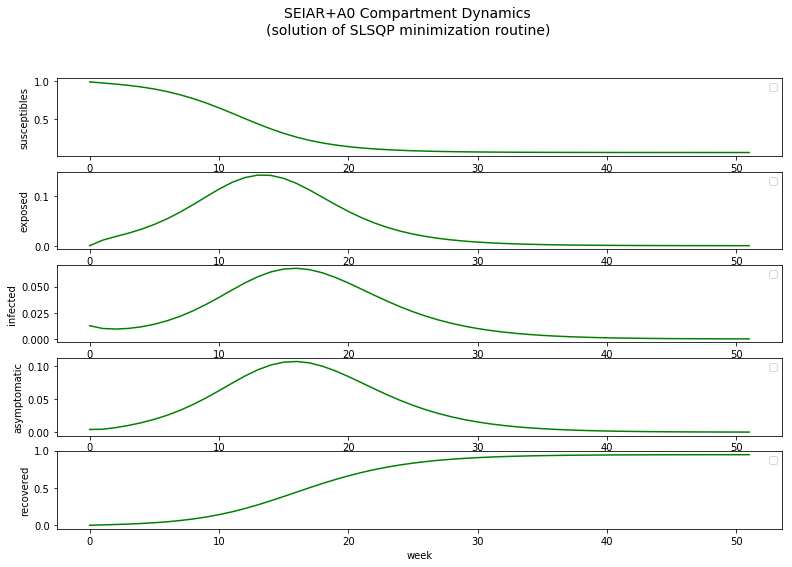

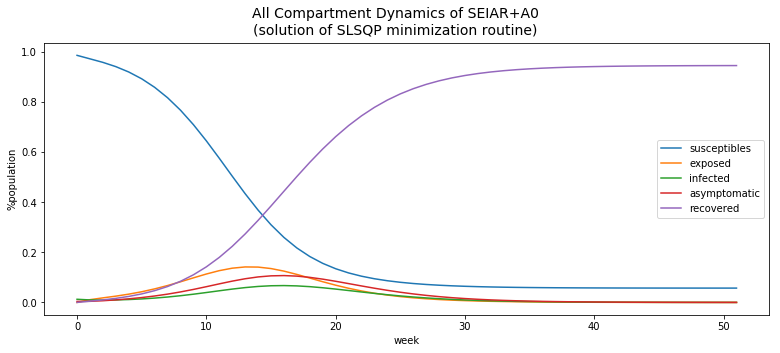

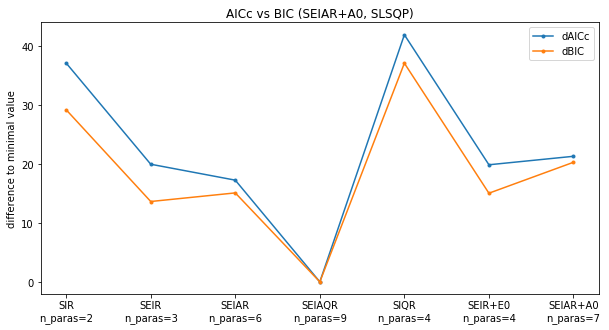

,AIC,AICc,BIC,R0,SSE,compartment_names,dAICc,dBIC,fixed_parameter_values,initial_guess,model,modelname,n_parameters,parameters,solution,w_akaike
0,-489.86,-489.36,-336.44,2.08,0.00376,"susceptibles, infected, recovered",37.11,29.19,"0.9873, 0.0127, 0.0","0.6, 0.43",1,SIR,2,"beta, alpha","0.6037, 0.4256",0.00000
0,-507.37,-506.52,-351.99,2.39,0.00258,"susceptibles, exposed, infected, recovered",19.95,13.63,"0.9873, 0.0, 0.0127, 0.0","0.94, 0.57, 1.08",2,SEIR,3,"beta, alpha, eta","0.9386, 0.5727, 1.0797",0.00005
0,-511.76,-509.22,-350.54,3.53,0.00211,"susceptibles, exposed, infected, asymptomatic,...",17.25,15.09,"0.9873, 0.0, 0.0127, 0.0, 0.0","0.81, 0.49, 0.44, 1.27, 0.38, 0.4",3,SEIAR,6,"beta, alpha, eta, q, p, gamma","0.9307, 0.2708, 0.6669, 1.216, 0.3361, 0.5954",0.00018
0,-530.75,-526.47,-365.62,4.42,0.00136,"susceptibles, exposed, infected, asymptomatic,...",0.00,0.00,"0.9873, 0.0, 0.0127, 0.0, 0.0, 0.0","0.91, 1.25, 0.35, 1.16, 0.17, 0.04, 0.35, 1.0",4,SEIAQR,9,"beta, alpha, gamma, eta, q, p, gamma, delta, my","1.2187, 0.7394, 0.7412, 1.391, 0.9737, 0.0, 0....",0.99970
0,-485.86,-484.55,-328.53,2.08,0.00376,"susceptibles, infected, quarentined, recovered",41.92,37.09,"0.9873, 0.0127, 0.0, 0.0","0.6, 0.41, 0.01, 1.16",5,SIQR,4,"beta, alpha, delta, my","0.6033, 0.4126, 0.0126, 1.16",0.00000
0,-507.91,-506.61,-350.59,2.52,0.00246,"susceptibles, exposed, infected, recovered",19.86,15.04,"0.9873, 0.0, 0.0127, 0.0","0.94, 0.57, 1.08, 0.1",6,SEIR+E0,4,"beta, alpha, eta, E0","1.0706, 0.6179, 0.8084, 0.0",0.00005
0,-508.52,-505.17,-345.34,4.38,0.00216,"susceptibles, exposed, infected, asymptomatic,...",21.30,20.28,"0.9873, 0.0, 0.0127, 0.0, 0.0","0.81, 0.49, 0.44, 1.27, 0.38, 0.4, 0.1",7,SEIAR+A0,7,"beta, alpha, eta, q, p, gamma, A0","0.8753, 0.3338, 0.4655, 1.2688, 0.3809, 0.3416...",0.00002


In [26]:
save_results = False
resolution = 300 # dpi for saving figures

#-----------------------------------------------------------------------------------------------------------
# CHOOSE MINIMIZATION METHOD
# ...either 'built_in_leastsq' or any method of scipy's optimize.minimize function

#################################
# built in ls (bounds not used)
#################################
#minimization_method = 'built_in_leastsq' #...doesnt seem to work at all... gives really bad fits!

#################################
# bounds on parameters usable for: 
#################################
minimization_method ='SLSQP'   
#minimization_method ='L-BFGS-B'
#minimization_method ='TNC'

#################################
# further methods
#################################
#minimization_method ='Nelder-Mead' # good fits, but negative parameters
#minimization_method ='CG'
#minimization_method ='BFGS' 
#minimization_method ='Powell'
#minimization_method ='COBYLA'  


# following methods not used so far...

#minimization_method ='dogleg'
#minimization_method ='Newton-CG'
#minimization_method ='trust-exact'
#minimization_method ='trust-ncg'
#minimization_method ='trust-krylov'

#################################
# function could be constrainted (but not really useful for us) for:
#################################
#minimization_method ='COBYLA'  
#minimization_method ='SLSQP'   
#minimization_method ='trust-constr'

#-----------------------------------------------------------------------------------------------------------


# prepare summary of results
summary = pd.DataFrame(columns=('model', 'modelname', 'parameters',                      
                                'n_parameters', 'solution', 'initial_guess',
                                'SSE','AIC','AICc','w_akaike','R0','BIC','dBIC')) 

# extra dictionary for the model and solution
parameter_solution={}

# execute the fit for each model
for model in range(1,8):
    
    ############# OPTIMIZATION #############

    if model == 6: # SEIR+E0
        
        # setup
        guess, y0, para_names, compartment_names, bnds, modelname = setup(2) # using SEIR setup
        print('--- ...plus fitting E0\n') # prints SEIR in setup(2)
        #y0 = None # needs to be constructed on the way
        para_names.append('E0')
        guess.append(0.1) # add E0 guess
        bnds = ((0,np.inf),(0,np.inf),(0,np.inf),(0,1)) # E0 in [0,1]
        modelname = 'SEIR+E0'
        
        # solve the ode system - the solution is in variable c
        if minimization_method == 'built_in_leastsq':
            print('Not implemented... it crashes anyway!') #(c,kvg) = optimize.leastsq(f_resid, guess)
        else:
            parameters_solution = optimize.minimize(f_leastsquares_E0,guess,method=minimization_method,bounds=bnds)
            c = parameters_solution.x

        # use solution c for plotting the results and evaluating the error
        print([y0[0],c[-1],y0[2],y0[3]])
        RES = integrate.odeint(lambda y,t: f(y,t,c[:-1],model),[y0[0],c[-1],y0[2],y0[3]],x_data) 
        y_data_sol = RES[:,2] # because except for SIR, I is always in thrids position
        print('\nE0_solution:    {}'.format(c[-1]))
    
    elif model == 7: # SEIAR+A0
        
        # setup
        guess, y0, para_names, compartment_names, bnds, modelname = setup(3) # using SEIAR setup
        print('--- ...plus fitting A0\n') # prints SEIR in setup(2)
        #y0 = None # needs to be constructed on the way
        para_names.append('A0')
        guess.append(0.1) # add A0 guess
        upperbound = np.inf
        bnds  = ((0,upperbound),(0,upperbound),(0,upperbound),(0,upperbound),(0,upperbound),(0,upperbound),(0,1))
        modelname = 'SEIAR+A0'
        
        # solve the ode system - the solution is in variable c
        if minimization_method == 'built_in_leastsq':
            print('Not implemented... it crashes anyway!') #(c,kvg) = optimize.leastsq(f_resid, guess)
        else:
            parameters_solution = optimize.minimize(f_leastsquares_A0,guess,method=minimization_method,bounds=bnds)
            c = parameters_solution.x

        # use solution c for plotting the results and evaluating the error
        print([y0[0],c[-1],y0[2],y0[3]])
        RES = integrate.odeint(lambda y,t: f(y,t,c[:-1],model),[y0[0],y0[1],y0[2],c[-1],y0[4]],x_data) 
        y_data_sol = RES[:,2] # because except for SIR, I is always in thrids position
        print('\nA0_solution:    {}'.format(c[-1]))
        
    else:

        # setup
        guess, y0, para_names, compartment_names, bnds, modelname = setup(model)

        # solve the ode system - the solution is in variable c
        if minimization_method == 'built_in_leastsq':
            (c,kvg) = optimize.leastsq(f_resid, guess)
        else:
            parameters_solution = optimize.minimize(f_leastsquares,guess,method=minimization_method,bounds=bnds)
            c = parameters_solution.x

        # use solution c for plotting the results and evaluating the error
        RES = integrate.odeint(lambda y,t: f(y,t,c,model),y0,x_data) 

        # should be done via I_position in setup.... RES[:,I_position] maybe
        if model == 1 or model == 5:
            y_data_sol = RES[:,1] # SIR -> I is in second position
        else:
            y_data_sol = RES[:,2] # because except for SIR, I is always in thrids position

  
    ############# ANALYSIS #############
    
    # calculate R0
    S_inf = RES[-1,0] # as an approximation of S_inf take last entry of S solution... not really S_inf though
    R0 = np.log2(S_inf) / (S_inf - 1)
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # What is R0? The basic reproductive number: 
    #
    #    " [...] R0, defined as the averagenumber of new infections caused by a single infected individual 
    #      introduced into a wholly susceptible population over the course of the infection of this individual. " 
    #                   source: http://www.math.u-szeged.hu/~rost/papers/Rost2011ebookKnipl.pdf
    #
    #     " One of the foremost and most valuable ideas that mathematical thinking 
    #       has brought to epidemic theory " (Heesterbeek & Dietz, 1996)
    #                   source: https://mysite.science.uottawa.ca/rsmith43/MAT3395/R0.pdf
    #
    # We use the final size equation (applicable to closed populations only, 
    # where the infection leads either to immunity or death) as given by source
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1578275/ (section 4.3):
    #
    #                                 R0 = ln(S_inf) / (S_inf - 1)
    #
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

    
    # calculate SSE and error y-y_sol
    SSE = 0
    error = []
    for i in x_data:
        i = int(i)
        SSE = SSE + (y_data[i]-y_data_sol[i])*(y_data[i]-y_data_sol[i])
        error.append(y_data[i]-y_data_sol[i])
      
    AIC, AICc = calc_AIC_AICc(SSE,len(c),len(y_data))
    BIC       = calc_BIC(SSE,len(c),len(y_data))
        
    # print results
    #np.set_printoptions(precision=3)
    print( "\nParameter solution:    {}".format(c))
    print( "SSE:                     {}".format(SSE))
    print( "AIC:                     {}".format(AIC) )
    print( "AICc:                    {}".format(AICc) )
    print( "BIC:                     {}".format(BIC) )
    print( "R0 approximation:        {}".format(R0) )
    
    # save solution in dict
    parameter_solution.update({model:c})
    
    # infectious fit only (also showing errors)
    plt.figure(figsize=(20,10))
    plt.suptitle("{} Data Fitting via {}".format(modelname,minimization_method), fontsize=17)
    plt.subplot(211)
    plt.plot(x_data, y_data,'.r', x_data,y_data_sol,'-b')
    plt.xlabel('week')
    plt.ylabel('Influenza Incidences')
    plt.legend(('data','fit'),loc=0)
    plt.subplot(212)
    plt.stem(x_data,error)
    plt.legend(loc=0)
    plt.xlabel('week')
    plt.ylabel('Residual Error')
    if save_results:
        plt.savefig('results\{}\{}_{}_Fit'.format(minimization_method,minimization_method,modelname),dpi=resolution)
    plt.show()
    
    # whole model with all compartments in subplots
    fig = plt.figure(figsize=(13,10))
    plt.suptitle("{} Compartment Dynamics\n(solution of {} minimization routine)".format(modelname, minimization_method), 
                 fontsize=14)
    n_comps = len(compartment_names)
    for comp in range(n_comps):
        plt.subplot(n_comps+1,1,comp+1)
        plt.plot(RES[:,comp], '-g')
        plt.legend(loc=0)
        plt.xlabel('week')
        plt.ylabel(compartment_names[comp])
    if save_results:
        plt.savefig('results\{}\{}_{}_CompartmentDynamicsSolution'.format(minimization_method,minimization_method, modelname),dpi=resolution)
    plt.show()
    
    # whole model with all compartments in one plot
    fig = plt.figure(figsize=(13,5))
    plt.suptitle("All Compartment Dynamics of {}\n(solution of {} minimization routine)".format(modelname, minimization_method), 
                 fontsize=14)
    n_comps = len(compartment_names)
    for comp in range(n_comps):
        plt.plot(RES[:,comp], label=compartment_names[comp])
        plt.legend(loc=0)
        plt.xlabel('week')
        plt.ylabel('%population')
    if save_results:
        plt.savefig('results\{}\{}_{}_AllCompartmentDynamicsSolution'.format(minimization_method,minimization_method, modelname),
                    dpi=resolution)
    plt.show()
    
    # store results in summary dataframe

    results_dict = { 'model':                   [model], 
                     'modelname':               [modelname], 
                     'parameters':              [ ", ".join(para_names)],
                     'n_parameters':            [len (para_names)],
                     'solution':                [ ", ".join(str(x) for x in np.round(c,decimals=4))],
                     'initial_guess':           [ ", ".join(str(x) for x in np.round(guess,decimals=4))],
                     'compartment_names':       [ ", ".join(compartment_names)],
                     'fixed_parameter_values':  [ ", ".join(str(x) for x in np.round(y0,decimals=4))],
                     'SSE':                     [SSE],
                     'BIC':                     [BIC],
                     'dBIC':                    [None], # can only be evaluated after computation of all models
                     'AIC':                     [AIC],
                     'AICc':                    [AICc],
                     'dAICc':                   [None], # can only be evaluated after computation of all models
                     'w_akaike':                [None], # can only be evaluated after computation of all models
                     'R0':                      [R0] } 
    
    results = pd.DataFrame(results_dict) 
    
    summary = pd.concat([summary, results])
    
# add dAICc
AICc_min = min(np.array(summary.AICc))
summary.dAICc = np.array(summary.AICc)-AICc_min

# add dBIC
BIC_min = min(np.array(summary.BIC))
summary.dBIC = np.array(summary.BIC)-BIC_min

# add w_akaike
w = [None]*len(summary)
for i in range(len(summary)):
    w[i] = np.exp(-summary.dAICc.iloc[i]/2) / sum(np.exp(-np.array(summary.dAICc)/2))
summary.w_akaike = w


# saving the results
if save_results:
    summary.to_csv('results\{}\{}_results.csv'.format(minimization_method,minimization_method),index=False)

# AIC BIC plot
plt.figure(figsize=(10,5))
x_AICBIC = range(1,len(summary.dBIC)+1)
plt.plot(x_AICBIC,summary.dAICc,'.-',label='dAICc')
plt.plot(x_AICBIC,summary.dBIC,'.-',label='dBIC')
ticklabels=[]
for tick in range(len(summary)):
    ticklabels.append('{}\nn_paras={}'.format(summary.modelname.iloc[tick],summary.n_parameters.iloc[tick]))
plt.xticks(np.arange(1,model+1), ticklabels)
#plt.xlabel('model')
plt.ylabel('difference to minimal value')
plt.legend()
plt.title('AICc vs BIC ({}, {})'.format(modelname,minimization_method))
if save_results:
    plt.savefig('results\{}\{}_AICvsBIC'.format(minimization_method,minimization_method),
                index=False,dpi=resolution)
plt.show()

# rounding and printing
decimals = pd.Series([5,5, 2,2,2,2,2,2], index=['w_akaike','SSE', 'BIC','dBIC','AIC','AICc','dAICc','R0'])
summary.round(decimals)

***"The importance of
carefully defining a small set of candidate models, based on the objective
and what is known about the problem, cannot be overemphasized."*** - K. P. BURNHAM AND D. R. ANDERSON, Model selection and multimodel inference: A practicalinformation-theoretic approach, Springer, New York, second ed., 2002. [p.106]

## First Sensitivity Analysis Try Outs


--- SIR --------------
Original solution: [0.60368836 0.42556909]


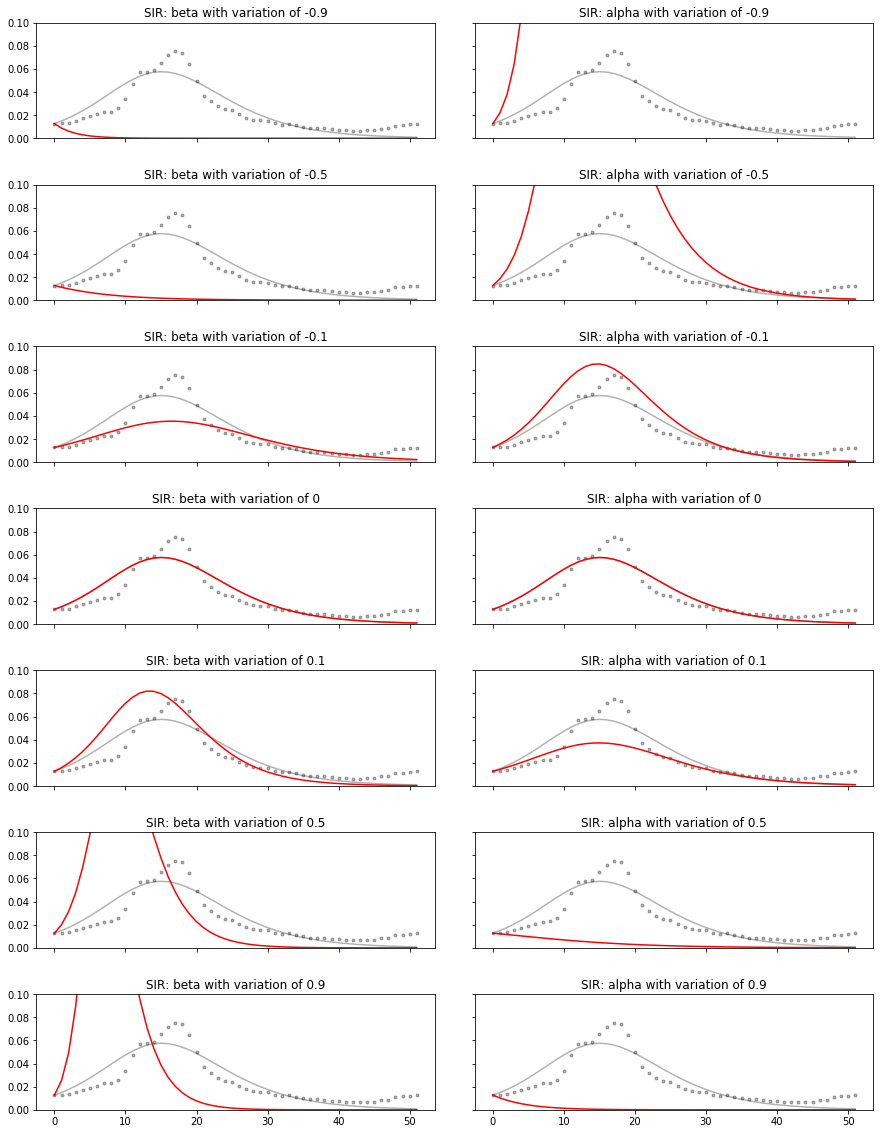


--- SEIR --------------
Original solution: [0.93858096 0.57273552 1.07971816]


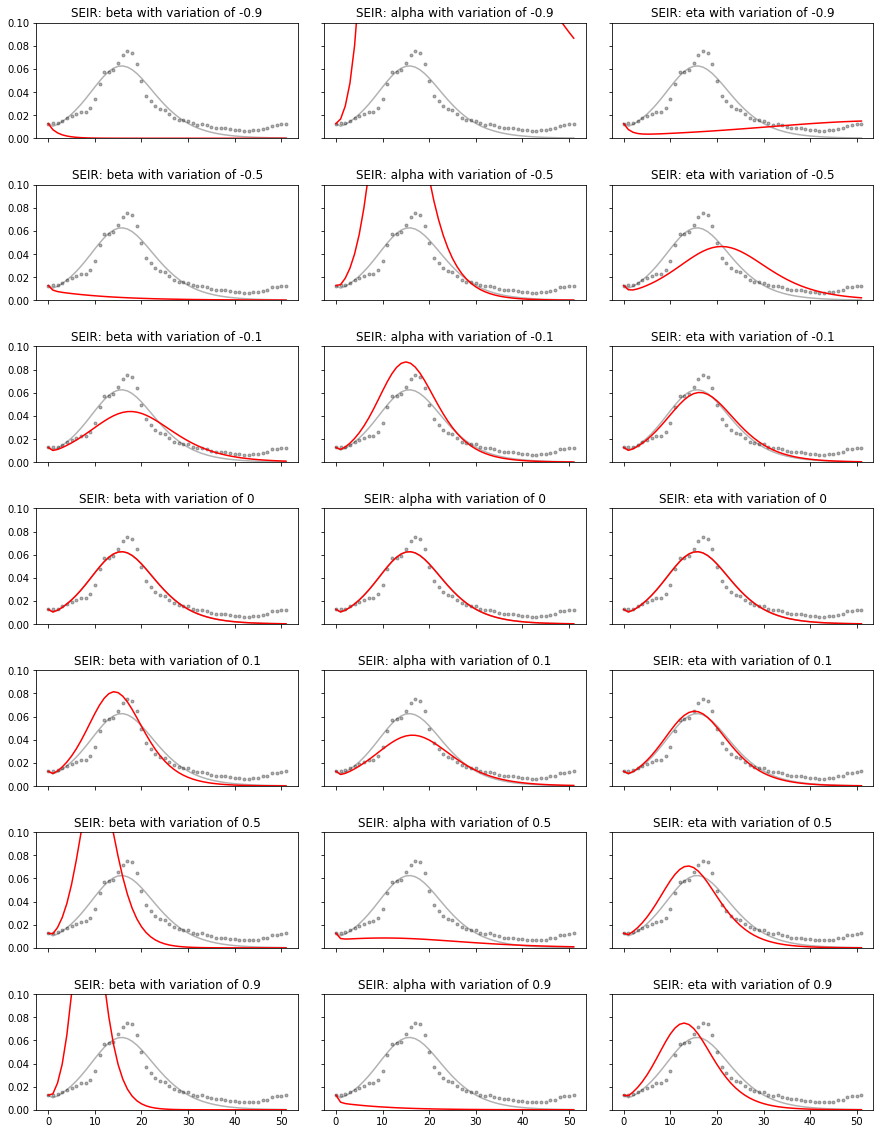


--- SEIAR --------------
Original solution: [0.93067831 0.27077292 0.666904   1.21603175 0.33611744 0.59542281]


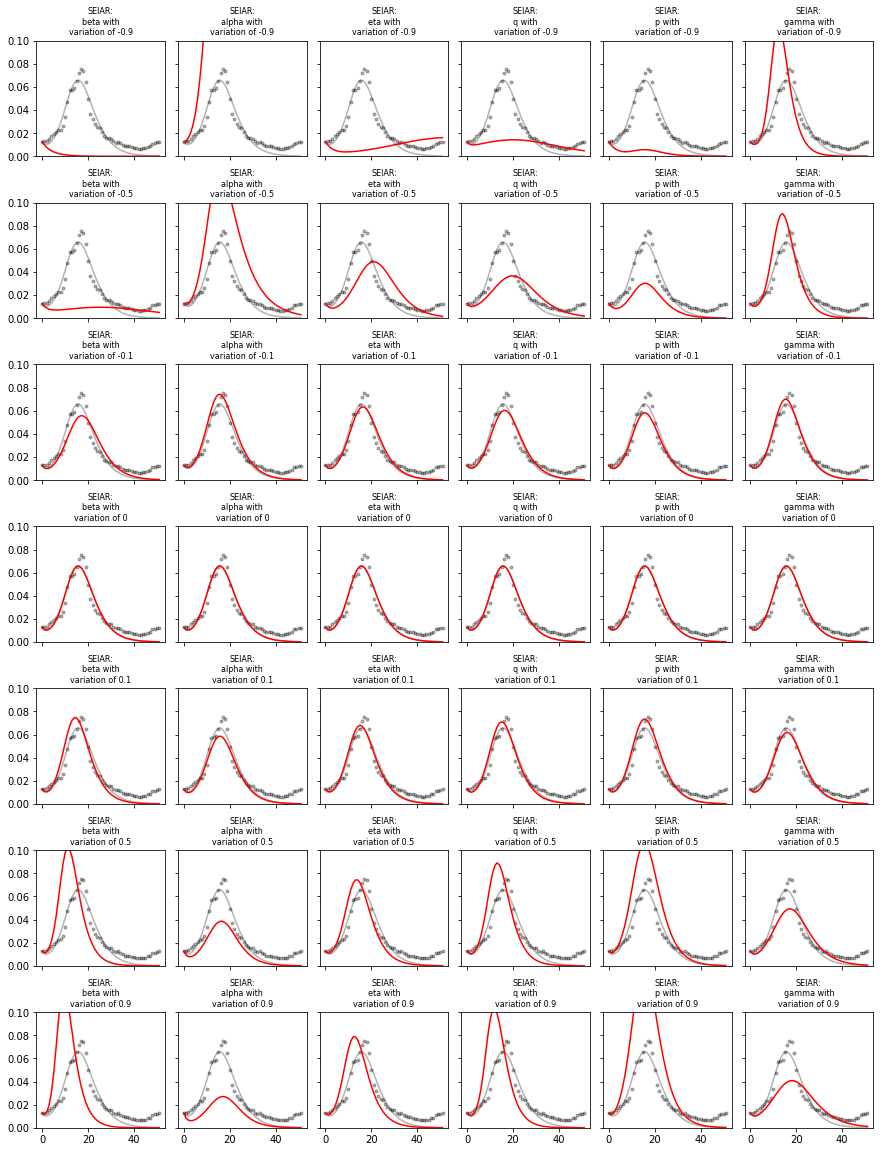


--- SEIAQR --------------
Original solution: [1.21871342e+00 7.39386284e-01 7.41182140e-01 1.39099369e+00
 9.73721472e-01 0.00000000e+00 2.13308414e-20 9.99997765e-01]


C:\Users\fabia\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


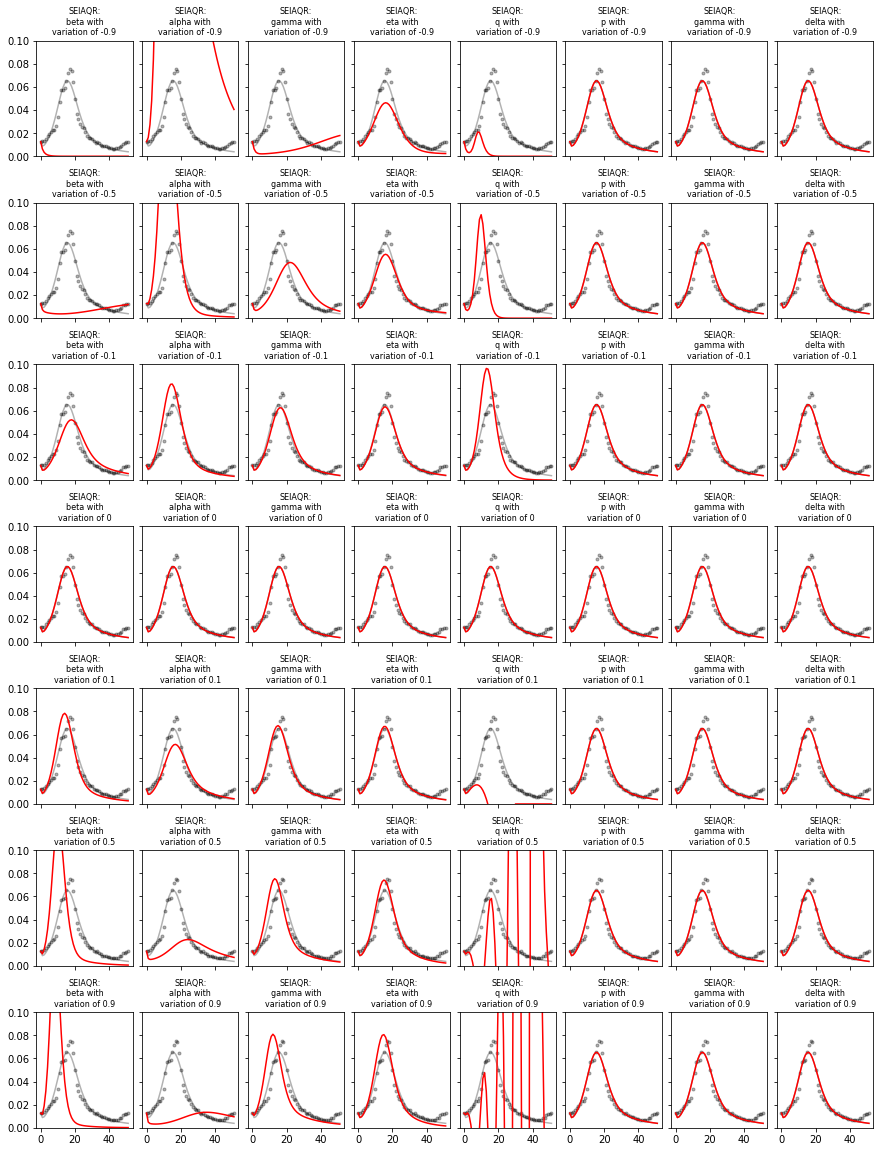


--- SIQR --------------
Original solution: [0.60327784 0.41260919 0.01261519 1.16000007]


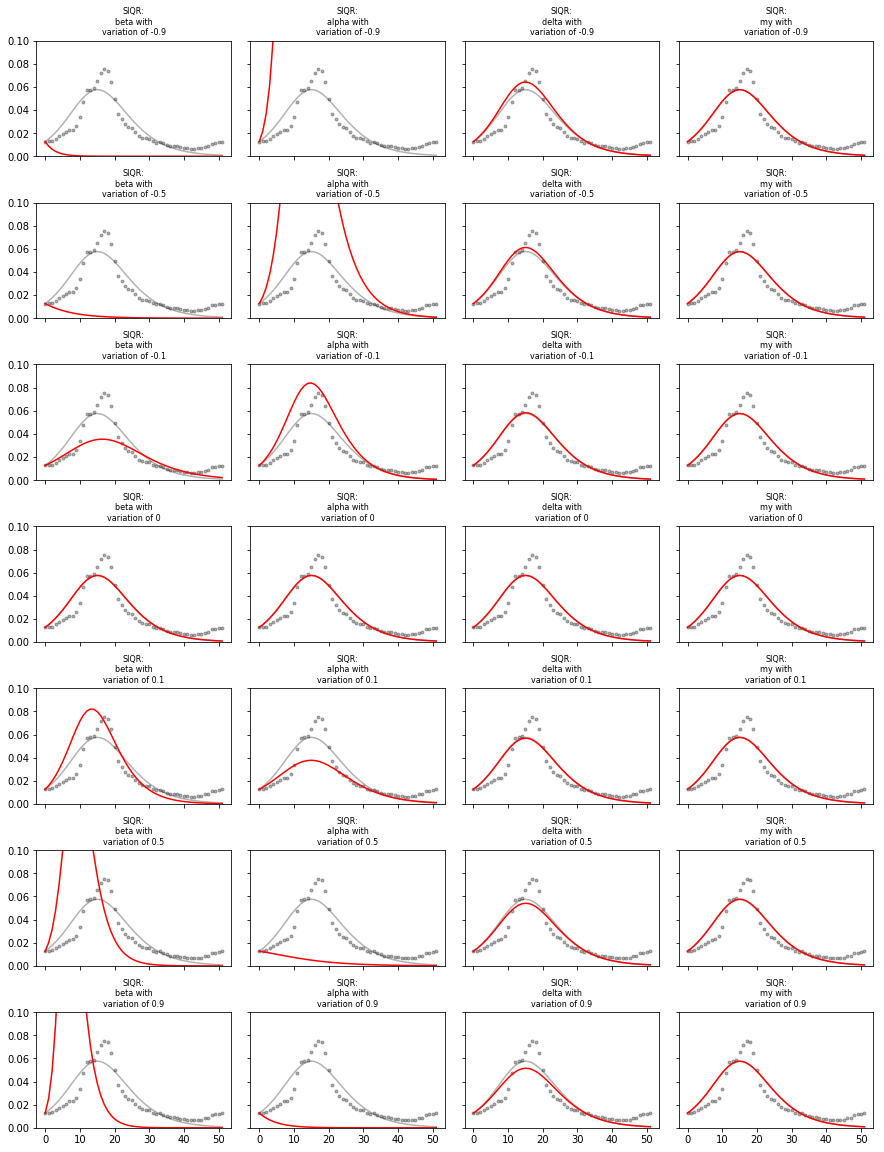

Model 6: TODO
Model 7: TODO


In [27]:
save_first_sensitivity = False
resolution = 300 # dpi for saving figures

def solve_with_solution(c,model):
    
    RES = integrate.odeint(lambda y,t: f(y,t,c,model),y0,x_data) 
    if model == 1 or model == 5:
        ode_solved_with_sol = RES[:,1] # SIR -> I is in second position ...also SIQR
    else:
        ode_solved_with_sol = RES[:,2] # because except for SIR, I is always in thrids position
    return ode_solved_with_sol


for model in parameter_solution:
    
    if model < 6:
        c_sol = parameter_solution[model]
        guess, y0, para_names, compartment_names, bnds, modelname = setup(model)
        y_data_solution = solve_with_solution(c_sol,model)
        print('Original solution: {}'.format("".join(str(c_sol))))
    
        n_paras = len(c_sol)
        variations = [-.9,-.5,-.1,0,.1,.5,.9]

        # plotting differnt perturbations:

        fig, axs = plt.subplots(len(variations),n_paras, figsize=(15, 20), 
                                facecolor='w', edgecolor='k', sharex=True, sharey=True)
        fig.subplots_adjust(hspace = .4, wspace=.1)

        axs = axs.ravel()    

        i = 0    
        for vari in variations:
            for para in range(n_paras):

                original_solution = np.array(c_sol) # caveat: somehow the conversion to np.array is very important!
                perturbed_solution = original_solution
                #print(perturbed_solution)
                perturbed_solution[para] = original_solution[para]+vari*original_solution[para]
                #print(para,vari,perturbed_solution,perturbed_solution[para])
                #print(perturbed_solution[para],vari,c_sol[para]+vari*c_sol[para])
                #print(c_sol)
                y_data_pert = solve_with_solution(perturbed_solution,model)

                axs[i].plot(x_data, y_data,'.k',alpha=.3)
                axs[i].plot(y_data_solution,'-k',alpha=.3)
                axs[i].plot(y_data_pert, '-r')

                #axs[i].set_xlim(x_data[0],x_data[-1])
                axs[i].set_ylim(0,0.1)

                #axs[i].set_xlabel('week')
                #axs[i].set_ylabel('%ILI')
                #axs[i].legend(('data','fit'),loc=0)
                if model>2:
                    axs[i].set_title('{}:\n{} with\nvariation of {}'.format(modelname,para_names[para],vari),
                                    fontsize=8)
                else:
                    axs[i].set_title('{}: {} with variation of {}'.format(modelname,para_names[para],vari))

                #axs[i]contourf(np.random.rand(10,10),5,cmap=plt.cm.Oranges)
                #axs[i].set_title(str(250+i))

                i+=1


        if save_first_sensitivity:
            plt.savefig('results\{}\{}_{}_manualSensitivityAnalysis'.format(minimization_method,minimization_method,modelname),dpi=resolution)
        #fig.suptitle("Parameter Variations of {}".format(modelname))
        plt.show()

    elif model == 6:
        print('Model 6: TODO')
    elif model == 7:
        print('Model 7: TODO')
    

# TODO: Bootstrap, X-validation, Sensitivity model 6 and 7 

## TODO DOCUMETNATION: add methods, results and discussion
https://www.cdc.gov/flu/about/season/flu-season-2017-2018.htm

In [28]:
#import sys
#!{sys.executable} -m pip install lmfit

# For the python package lmfit definitely check out:
# https://buildmedia.readthedocs.org/media/pdf/lmfit-py/0.8.3/lmfit-py.pdf